In [25]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## Load the files 

In [17]:
#Load the tfifdf matrix
try:
    tfidf_matrix = pd.read_csv('./tfidf_matrix.csv')
    print('Data load sucessfully:', len(tfidf_matrix), 'rows loaded')
except:
    print('Error: The file is empty or corrupted or does not exist.')

Data load sucessfully: 94032 rows loaded


In [3]:
# Load the recommendations dictionary from the file
try:
    with open('recommendations_no_outliers.pkl', 'rb') as f:
        recommendations_no_outliers = pickle.load(f)
    print("Recommendations loaded successfully.")
    # To avoid printing the entire dictionary, we print a summary or a subset
    print(f"Number of items in recommendations: {len(recommendations_no_outliers)}")
    #Print first 5 items
    for key in list(recommendations_no_outliers.keys())[:5]:
        print(f"{key}: {recommendations_no_outliers[key]}")
except EOFError:
    print("Error: The file is empty or corrupted.")


Recommendations loaded successfully.
Number of items in recommendations: 94032
0: [50887 85091 32084     0 73879 79702   455 30376  8199]
1: [35903 27399  2216 58191     1 89349 59197 83120 64844]
2: [47213 47101 76754 35142 28135  7711 93494 11154 88151]
3: [50075     3 19357  3383 26498 68853 40772 38163 40254]
4: [25237 77896 51734 65972 54097 17628 69652 72103 54726]


In [8]:
# Load the recommendations dictionary from the file
try:
    with open('recommendations_with_outliers.pkl', 'rb') as f:
        recommendations_with_outliers = pickle.load(f)
    print("Recommendations loaded successfully.")
    # To avoid printing the entire dictionary, we print a summary or a subset
    print(f"Number of items in recommendations: {len(recommendations_no_outliers)}")
    #Print first 5 items
    for key in list(recommendations_with_outliers.keys())[:5]:
        print(f"{key}: {recommendations_with_outliers[key]}")
except EOFError:
    print("Error: The file is empty or corrupted.")


Recommendations loaded successfully.
Number of items in recommendations: 94032
0: [50887 85091 32084     0 73879 79702   455 30376  8199]
1: [12702 40885 12430 64844 35903 58191 59197 44724  7489]
2: [    2 47101 76754 35142 54342 11154 59934 31758  7711]
3: [50075 65971     3  3383 26498 68853 40772 38163 40254]
4: [25237 77896 65972 51734 54097 17628 69652 72103 54726]


## Helper function

In [19]:
# Function to calculate cosine similarity between a product and its recommended items
def calculate_cosine_similarity(tfidf_matrix, product_index, recommended_indices):
    product_vector = tfidf_matrix.iloc[product_index].values.reshape(1, -1)
    recommended_vectors = tfidf_matrix.iloc[recommended_indices].values
    
    # Compute cosine similarity
    similarities = cosine_similarity(product_vector, recommended_vectors)[0]
    return similarities

In [20]:
# Function to calculate average cosine similarity for all products
def average_cosine_similarity(tfidf_matrix, recommendations):
    total_similarity = 0
    count = 0
    
    for product_index, recommended_indices in recommendations.items():
        if len(recommended_indices) > 1:  # Check if there are recommendations
            # Exclude the item itself
            similarities = calculate_cosine_similarity(tfidf_matrix, product_index, recommended_indices[1:])
            total_similarity += similarities.sum()
            count += len(similarities)
    
    return total_similarity / count if count != 0 else 0

In [21]:
# Function to calculate intra-list similarity for a list of recommended items
def intra_list_similarity(tfidf_matrix, recommended_indices):
    if len(recommended_indices) < 2:
        return 0
    
    vectors = tfidf_matrix.iloc[recommended_indices].values
    pairwise_similarities = cosine_similarity(vectors)
    
    # Only consider the upper triangle of the similarity matrix, excluding the diagonal
    num_pairs = len(recommended_indices) * (len(recommended_indices) - 1) / 2
    return pairwise_similarities.sum() / (2 * num_pairs)


In [22]:
# Function to calculate average intra-list similarity for all products
def average_intra_list_similarity(tfidf_matrix, recommendations):
    total_similarity = 0
    count = 0
    
    for recommended_indices in recommendations.values():
        if len(recommended_indices) > 1:  # Check if there are recommendations
            total_similarity += intra_list_similarity(tfidf_matrix, recommended_indices[1:])
            count += 1
    
    return total_similarity / count if count != 0 else 0

## Average cosine similarity and average intra-list similarity for all data

In [26]:

average_similarity = average_cosine_similarity(tfidf_matrix, recommendations_with_outliers)
average_intra_list_sim = average_intra_list_similarity(tfidf_matrix, recommendations_with_outliers)

print(f"Average Cosine Similarity: {average_similarity}")
print(f"Average Intra-List Similarity: {average_intra_list_sim}")

Average Cosine Similarity: 0.9999995272161474
Average Intra-List Similarity: 1.1428566802923616


## Partition and group data points

In [27]:
# Function to partition the recommendations dictionary into N groups
def partition_recommendations(recommendations, num_groups):
    keys = list(recommendations.keys())
    group_size = len(keys) // num_groups
    remainder = len(keys) % num_groups
    
    groups = []
    start = 0
    
    for i in range(num_groups):
        end = start + group_size + (1 if i < remainder else 0)
        group_keys = keys[start:end]
        group_recommendations = {key: recommendations[key] for key in group_keys}
        groups.append(group_recommendations)
        start = end
    
    return groups

In [28]:
# Function to calculate the average metrics for a group of recommendations
def average_metrics_for_group(tfidf_matrix, group_recommendations):
    avg_cosine_similarity = average_cosine_similarity(tfidf_matrix, group_recommendations)
    avg_intra_list_similarity = average_intra_list_similarity(tfidf_matrix, group_recommendations)
    return avg_cosine_similarity, avg_intra_list_similarity

In [29]:
# Partition both dictionaries into 25 groups using the same keys
num_groups = 25
recommendation_with_outliers_groups = partition_recommendations(recommendations_with_outliers, num_groups)
recommendation_no_outliers_groups = partition_recommendations(recommendations_no_outliers, num_groups)

# Calculate average metrics for each group in both dictionaries
average_cosine_similarities = []
average_intra_list_similarities = []
average_cosine_similarities_no_outliers = []
average_intra_list_similarities_no_outliers = []

for group_with_outliers, group_no_outliers in zip(recommendation_with_outliers_groups, recommendation_no_outliers_groups):
    avg_cos_sim, avg_intra_sim = average_metrics_for_group(tfidf_matrix, group_with_outliers)
    avg_cos_sim_no_outliers, avg_intra_sim_no_outliers = average_metrics_for_group(tfidf_matrix, group_no_outliers)
    
    average_cosine_similarities.append(avg_cos_sim)
    average_intra_list_similarities.append(avg_intra_sim)
    average_cosine_similarities_no_outliers.append(avg_cos_sim_no_outliers)
    average_intra_list_similarities_no_outliers.append(avg_intra_sim_no_outliers)


## Save groupings

In [38]:
# Save the recommendations dictionary to a file
with open('recommendation_with_outlier_groups.pkl', 'wb') as f:
    pickle.dump(recommendation_with_outliers_groups, f)

print("Recommendations saved successfully.")

Recommendations saved successfully.


In [36]:
# Save the recommendations dictionary to a file
with open('recommendation_no_outliers_groups.pkl', 'wb') as f:
    pickle.dump(recommendation_no_outliers_groups, f)

print("Recommendations saved successfully.")

Recommendations saved successfully.


In [30]:
# Create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Group': range(1, num_groups + 1),
    'Average Cosine Similarity': average_cosine_similarities,
    'Average Cosine Similarity (No Outliers)': average_cosine_similarities_no_outliers,
    'Average Intra-List Similarity': average_intra_list_similarities,
    'Average Intra-List Similarity (No Outliers)': average_intra_list_similarities_no_outliers
})

print(metrics_df)


    Group  Average Cosine Similarity  Average Cosine Similarity (No Outliers)  \
0       1                   1.000000                                 0.998419   
1       2                   1.000000                                 0.998293   
2       3                   1.000000                                 0.998447   
3       4                   1.000000                                 0.998270   
4       5                   1.000000                                 0.998424   
5       6                   1.000000                                 0.998649   
6       7                   0.999999                                 0.998150   
7       8                   1.000000                                 0.998018   
8       9                   1.000000                                 0.998193   
9      10                   1.000000                                 0.998137   
10     11                   0.999999                                 0.998250   
11     12                   

## Visualising our metrics

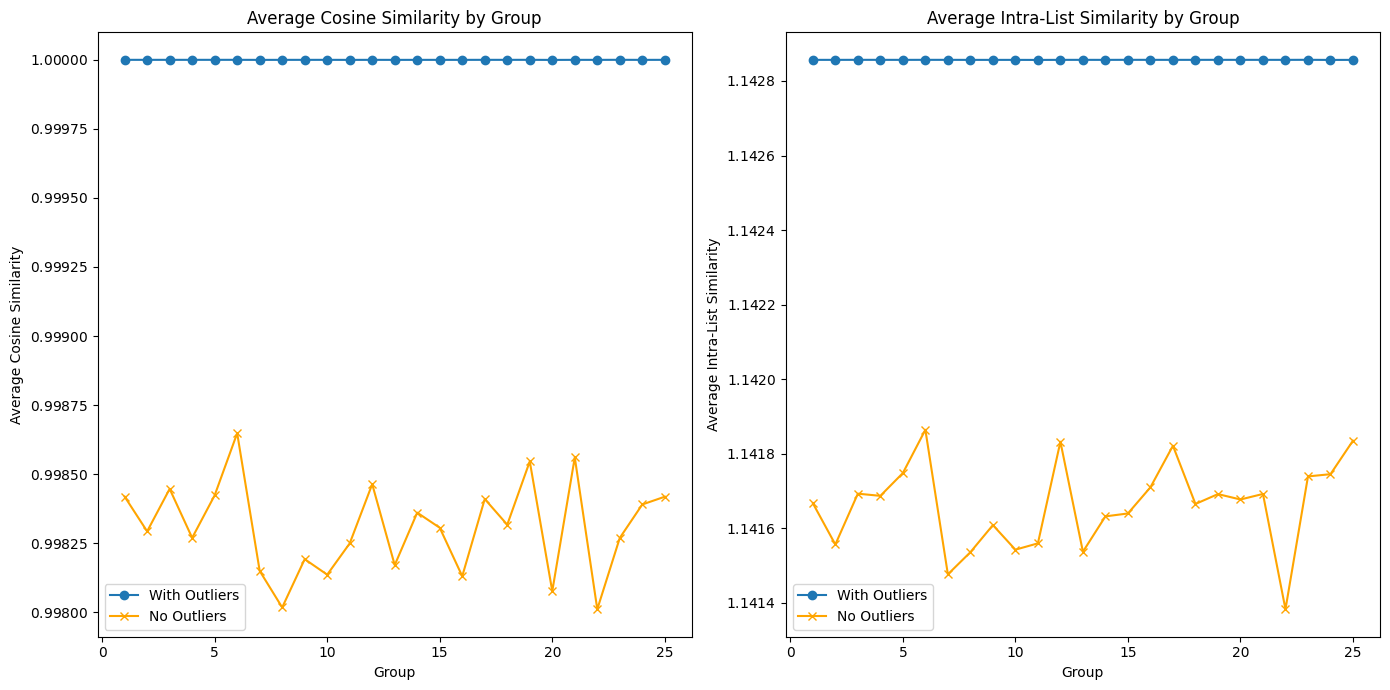

In [31]:

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot Average Cosine Similarity
plt.subplot(1, 2, 1)
plt.plot(metrics_df['Group'], metrics_df['Average Cosine Similarity'], marker='o', label='With Outliers')
plt.plot(metrics_df['Group'], metrics_df['Average Cosine Similarity (No Outliers)'], marker='x', label='No Outliers', color='orange')
plt.title('Average Cosine Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Average Cosine Similarity')
plt.legend()

# Customize y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

# Plot Average Intra-List Similarity
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Group'], metrics_df['Average Intra-List Similarity'], marker='o', label='With Outliers')
plt.plot(metrics_df['Group'], metrics_df['Average Intra-List Similarity (No Outliers)'], marker='x', label='No Outliers', color='orange')
plt.title('Average Intra-List Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Average Intra-List Similarity')
plt.legend()

# Customize y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.show()

In [32]:
# Calculate differences between the metrics with and without outliers
metrics_df['Difference in Cosine Similarity'] = metrics_df['Average Cosine Similarity'] - metrics_df['Average Cosine Similarity (No Outliers)']
metrics_df['Difference in Intra-List Similarity'] = metrics_df['Average Intra-List Similarity'] - metrics_df['Average Intra-List Similarity (No Outliers)']


In [33]:
metrics_df.to_csv('metrics_df_both_with_and_without_outliers.csv', index=False)

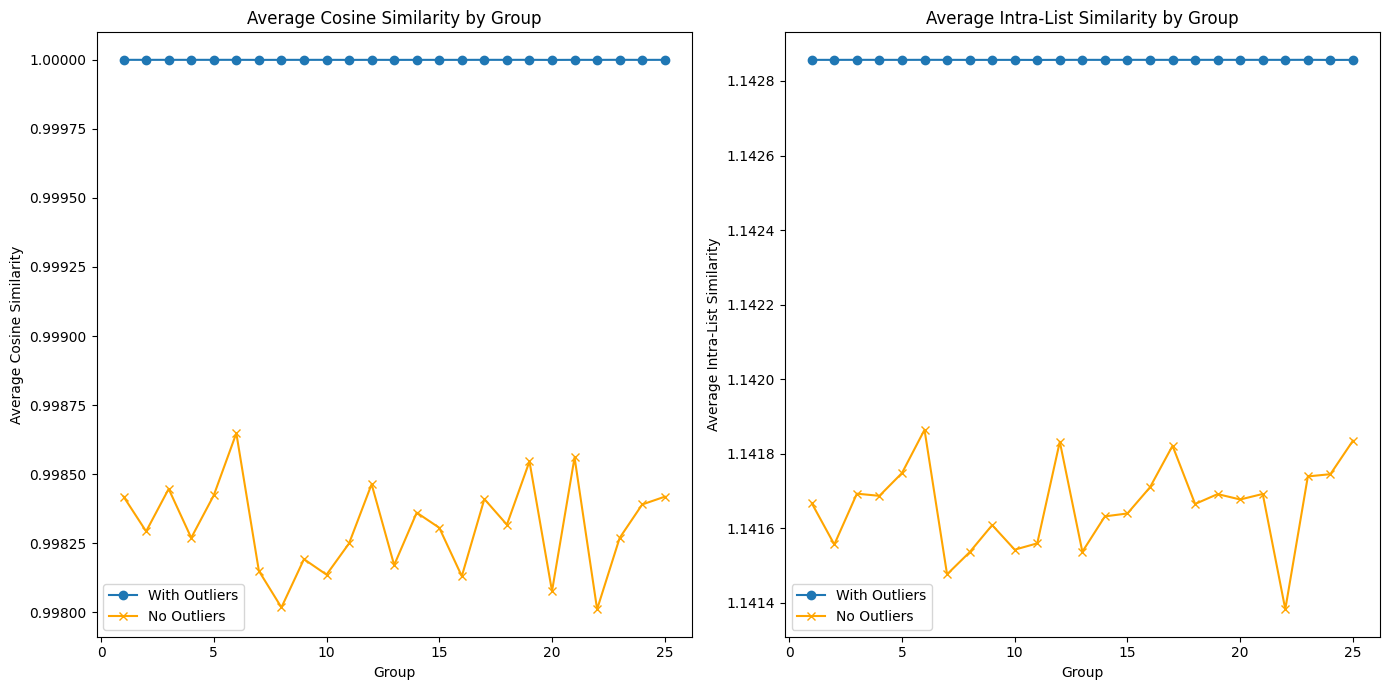

In [34]:
# Plotting the average metrics with and without outliers
plt.figure(figsize=(14, 7))

# Plot Average Cosine Similarity
plt.subplot(1, 2, 1)
plt.plot(metrics_df['Group'], metrics_df['Average Cosine Similarity'], marker='o', label='With Outliers')
plt.plot(metrics_df['Group'], metrics_df['Average Cosine Similarity (No Outliers)'], marker='x', label='No Outliers', color='orange')
plt.title('Average Cosine Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Average Cosine Similarity')
plt.legend()

# Plot Average Intra-List Similarity
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Group'], metrics_df['Average Intra-List Similarity'], marker='o', label='With Outliers')
plt.plot(metrics_df['Group'], metrics_df['Average Intra-List Similarity (No Outliers)'], marker='x', label='No Outliers', color='orange')
plt.title('Average Intra-List Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Average Intra-List Similarity')
plt.legend()

plt.savefig("average_metric_graphs.png")

plt.tight_layout()
plt.show()


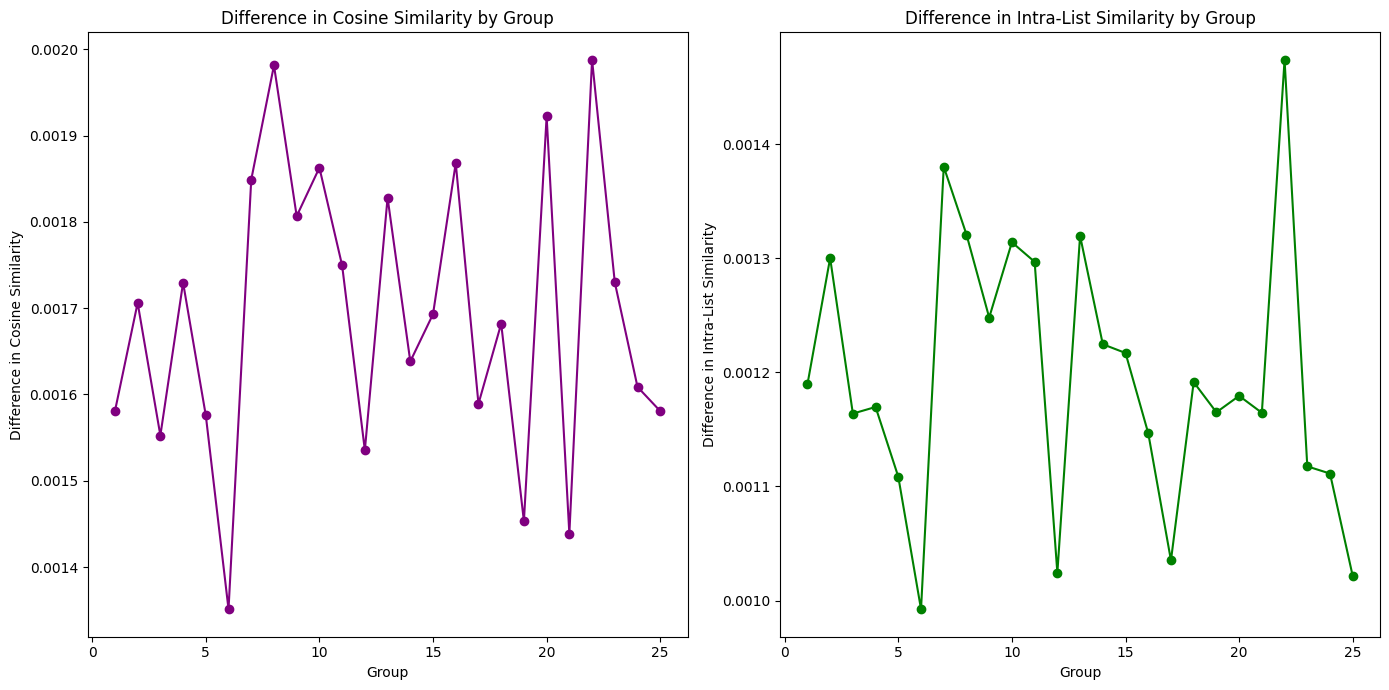

In [35]:
# Plotting the differences
plt.figure(figsize=(14, 7))

# Plot Difference in Cosine Similarity
plt.subplot(1, 2, 1)
plt.plot(metrics_df['Group'], metrics_df['Difference in Cosine Similarity'], marker='o', color='purple')
plt.title('Difference in Cosine Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Difference in Cosine Similarity')

# Plot Difference in Intra-List Similarity
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Group'], metrics_df['Difference in Intra-List Similarity'], marker='o', color='green')
plt.title('Difference in Intra-List Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Difference in Intra-List Similarity')

plt.savefig("difference_in_metrics_graphs.png")
plt.tight_layout()
plt.show()


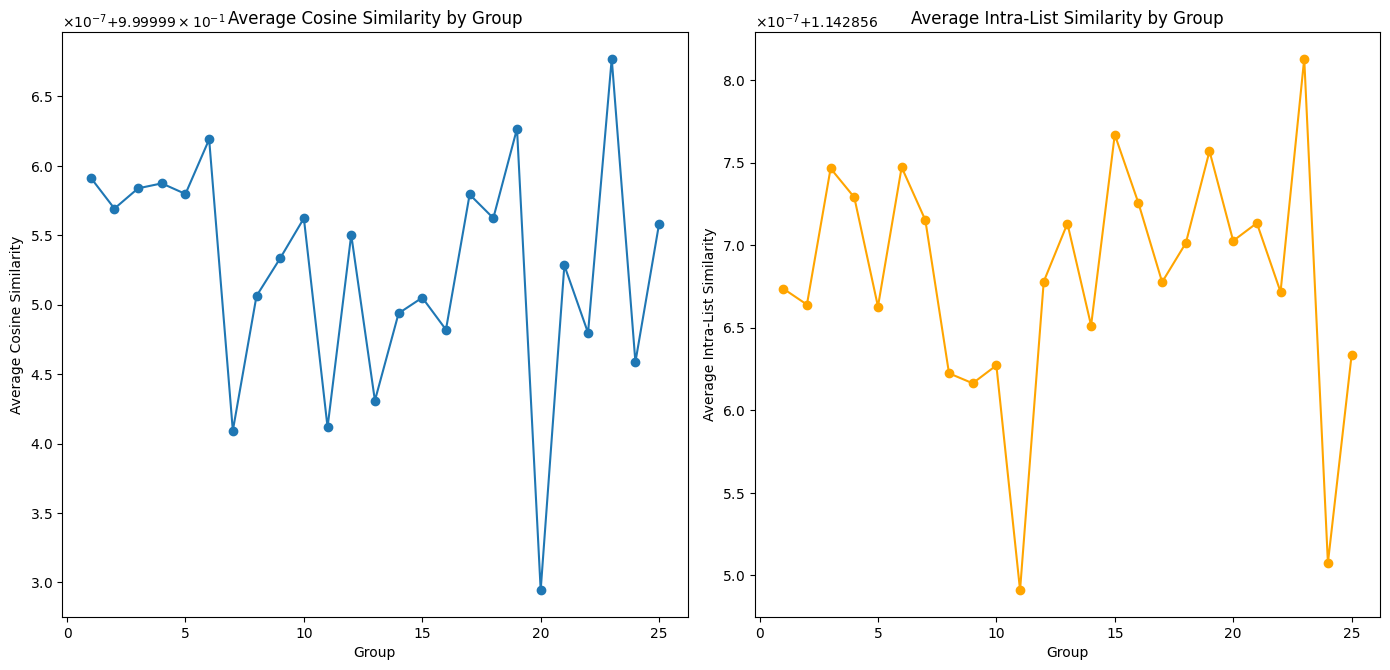

In [41]:
# Plotting the results with adjusted y-axis labels
plt.figure(figsize=(14, 7))

# Plot Average Cosine Similarity
plt.subplot(1, 2, 1)
plt.plot(metrics_df['Group'], metrics_df['Average Cosine Similarity'], marker='o')
plt.title('Average Cosine Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Average Cosine Similarity')

# Customize y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

# Plot Average Intra-List Similarity
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Group'], metrics_df['Average Intra-List Similarity'], marker='o', color='orange')
plt.title('Average Intra-List Similarity by Group')
plt.xlabel('Group')
plt.ylabel('Average Intra-List Similarity')

# Customize y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.savefig('metrics-with-outliers.png')
plt.show()
